In [1]:
import networkx as nx
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from simulate import ODE_simulate, GILL_simulate
from plot_module import plot_ODE, plot_gillespie, plot_network
from sim_param_from_network import names_from_network, gillespie_reaction_dict_from_network, dataframes_from_network, ODE_from_network

In [2]:
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)

## Define network topology and numeric parameters

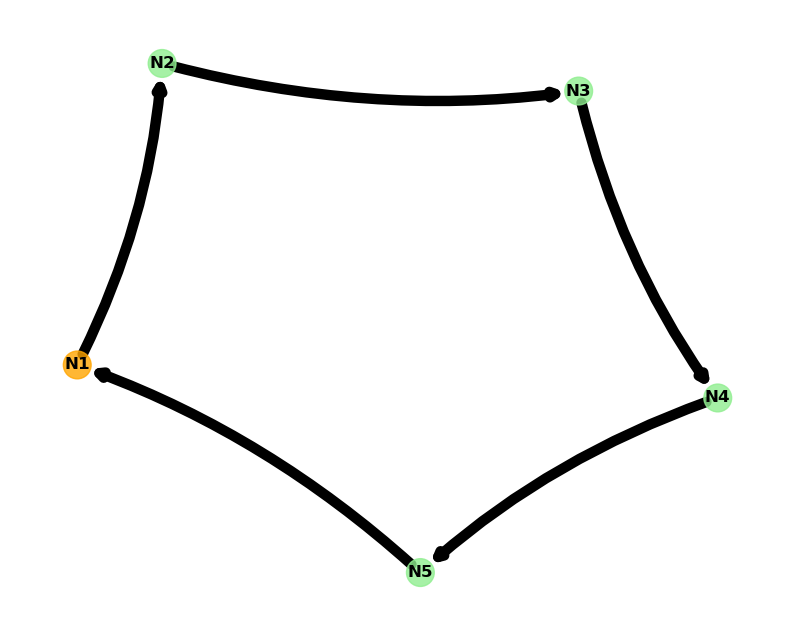

In [9]:
G = nx.DiGraph()

G.add_node('N1', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N2', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N3', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N4', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N5', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)

G.add_edge('N1', 'N2', rate=0.15)
G.add_edge('N2', 'N3', rate=0.15)
G.add_edge('N3', 'N4', rate=0.15)
G.add_edge('N4', 'N5', rate=0.15)
G.add_edge('N5', 'N1', rate=0.15)

# G.add_edge('N2', 'N1', rate=0.01)
# G.add_edge('N3', 'N2', rate=0.01)
# G.add_edge('N1', 'N3', rate=0.01)

plot_network(G)
VARS, COMP = names_from_network(G)

# set a given starting state
start_state = [190, 20, 190, 20, 190, 20, 190, 20, 190, 20]

## Get ODE representation of network, and run simulation

In [10]:
ODE_model = ODE_from_network(G)

> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	N1_wt, N1_mt, N2_wt, N2_mt, N3_wt, N3_mt, N4_wt, N4_mt, N5_wt, N5_mt = z
	return [
		# ΔN1_wt/Δt
		(N1_wt*((0.07 + 0.1*(200-N1_wt-(0.5*N1_mt)))-(0.07)-(0.15)))+(N5_wt*0.15),
		# ΔN1_mt/Δt
		(N1_mt*((0.07 + 0.1*(200-N1_wt-(0.5*N1_mt)))-(0.07)-(0.15)))+(N5_mt*0.15),
		# ΔN2_wt/Δt
		(N2_wt*((0.07)-(0.07)-(0.15)))+(N1_wt*0.15),
		# ΔN2_mt/Δt
		(N2_mt*((0.07)-(0.07)-(0.15)))+(N1_mt*0.15),
		# ΔN3_wt/Δt
		(N3_wt*((0.07)-(0.07)-(0.15)))+(N2_wt*0.15),
		# ΔN3_mt/Δt
		(N3_mt*((0.07)-(0.07)-(0.15)))+(N2_mt*0.15),
		# ΔN4_wt/Δt
		(N4_wt*((0.07)-(0.07)-(0.15)))+(N3_wt*0.15),
		# ΔN4_mt/Δt
		(N4_mt*((0.07)-(0.07)-(0.15)))+(N3_mt*0.15),
		# ΔN5_wt/Δt
		(N5_wt*((0.07)-(0.07)-(0.15)))+(N4_wt*0.15),
		# ΔN5_mt/Δt
		(N5_mt*((0.07)-(0.07)-(0.15)))+(N4_mt*0.15),
		]


> Final counts of mt and wt in each compartment:
N1_wt	190.0	
N1_mt	20.0	
N2_wt	190.0	
N2_mt	20.0	
N3_wt	190.0	
N3_mt	20.0	
N4_wt	190.0	
N4_mt	20.0	
N5_wt	190.0	
N5_mt	20.0	

> Final effective population sizes in each compartment:
N1	200.0	
N2	200.0	
N3	200.0	
N4	200.0	
N5	200.0	


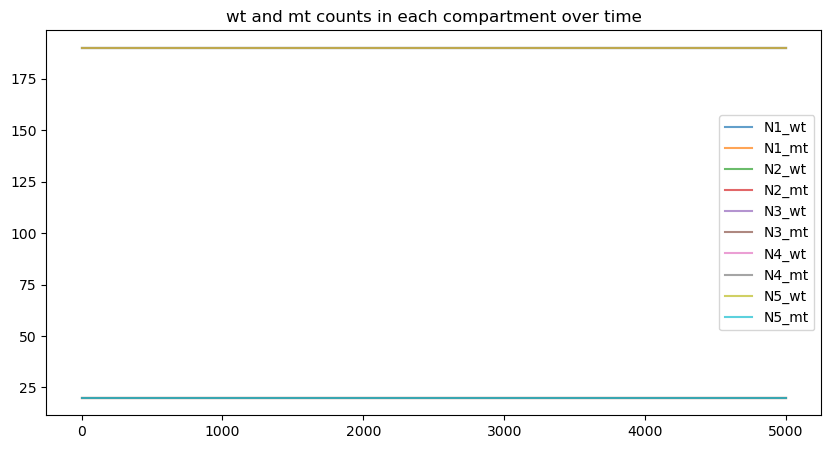

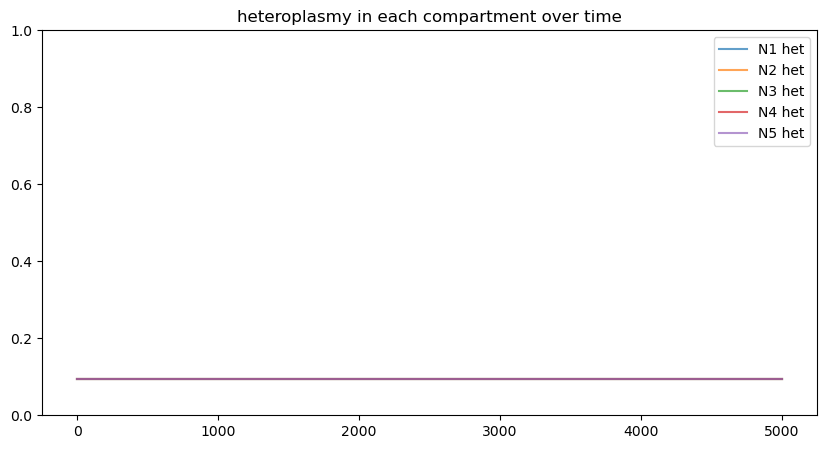

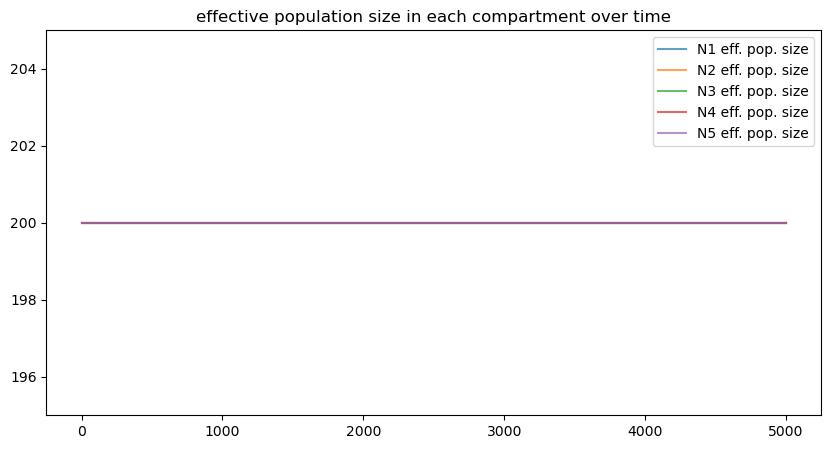

In [11]:
ode_results = ODE_simulate(ODE_model, TIME_POINTS, start_state)
plot_ODE(ode_results, TIME_POINTS, 0.5, VARS, COMP)

## Get gillespie simulation for network

In [12]:
gill_param = gillespie_reaction_dict_from_network(G)

> Reactions:
react.#	state i	type	rate	update to system
0	0	birth	-1	[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1	1	birth	-1	[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2	2	birth	0.07	[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
3	3	birth	0.07	[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
4	4	birth	0.07	[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
5	5	birth	0.07	[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
6	6	birth	0.07	[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
7	7	birth	0.07	[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
8	8	birth	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
9	9	birth	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10	0	death	0.07	[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11	1	death	0.07	[0, -1, 0, 0, 0, 0, 0, 0, 0, 0]
12	2	death	0.07	[0, 0, -1, 0, 0, 0, 0, 0, 0, 0]
13	3	death	0.07	[0, 0, 0, -1, 0, 0, 0, 0, 0, 0]
14	4	death	0.07	[0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
15	5	death	0.07	[0, 0, 0, 0, 0, -1, 0, 0, 0, 0]
16	6	death	0.07	[0, 0, 0, 0, 0, 0, -1, 0, 0, 0]
17	7	death	0.07	[0, 0, 0, 0, 0, 0, 0, -1, 0, 0]
18	8	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, -1, 0]
19	9	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
20	0	trn

In [13]:
gill_results = GILL_simulate(gill_param, TIME_POINTS, start_state, replicates=500)

simulating...


> Final mean counts of mt and wt in each compartment:
N1_wt	178.118	
N1_mt	46.254	
N2_wt	178.396	
N2_mt	46.092	
N3_wt	177.648	
N3_mt	45.664	
N4_wt	177.652	
N4_mt	45.988	
N5_wt	177.146	
N5_mt	46.068	

> Final mean heteroplasmy in each compartment:
N1	0.1553	
N2	0.1544	
N3	0.1549	
N4	0.1554	
N5	0.1555	

> Final mean effective population sizes in each compartment:
N1	201.245	
N2	201.442	
N3	200.48	
N4	200.646	
N5	200.18	

> Change in mean heteroplasmy: 
start: 0.0952
final: 0.1551
delta: 0.0599


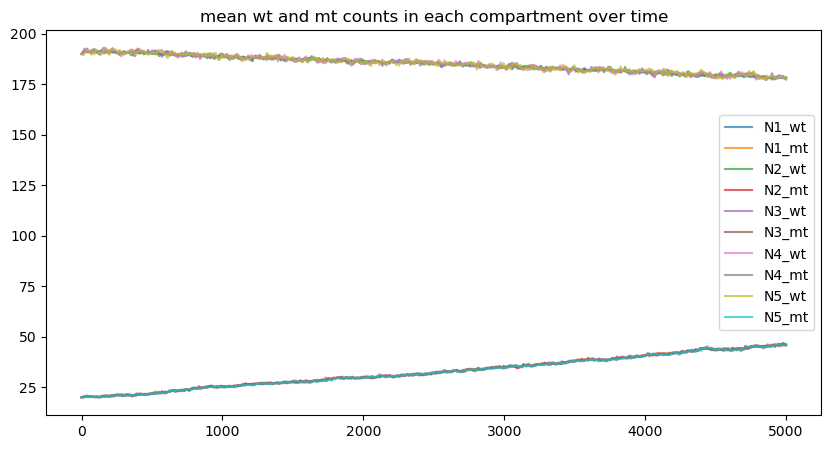

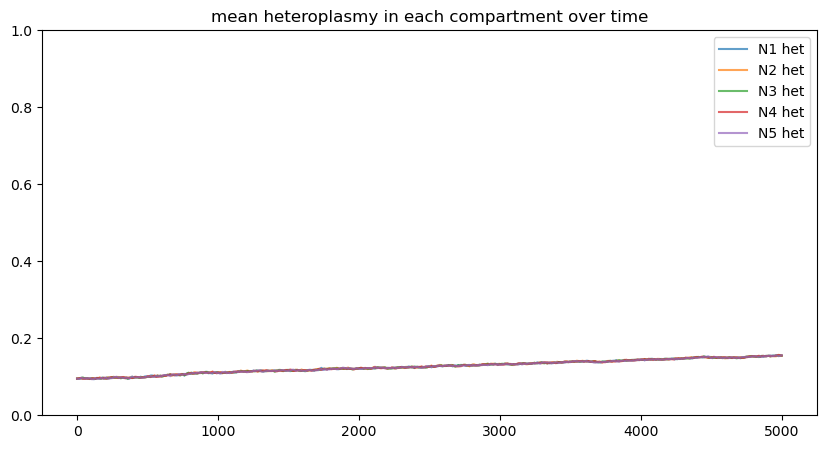

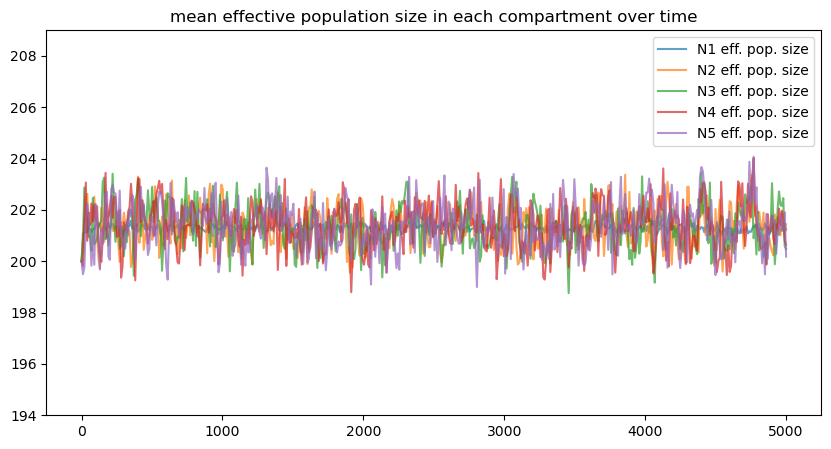

In [14]:
plot_gillespie(gill_results, TIME_POINTS, 0.5, VARS, COMP)